## Set up

Install required packages and load relevant data.

These functions derived from Roger's prepare data notebook

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
from joblib import dump
from src.data import make_dataset
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
project_dir = Path.cwd().parent
report_dir = project_dir / 'reports'
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

## Download and Prepare Data

In [4]:
competition = 'uts-advdsi-nba-career-prediction'
make_dataset.download_data(competition=competition,
                           path=raw_data_dir,
                           unzip=True)

In [5]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')
df_train.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6856.971000,7798.50000,62.777875,18.576662,7.267088,2.807037,6.231212,44.608900,0.264525,0.816562,...,1.947788,71.365825,1.077838,2.168500,3.245300,1.624513,0.648687,0.245212,1.257763,0.833625
std,3977.447579,2309.54541,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,...,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,4.000000,3799.00000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,...,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,3413.750000,5798.75000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,...,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,6787.500000,7798.50000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,...,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,10299.250000,9798.25000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,...,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,13798.000000,11798.00000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,...,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [6]:
X_test = pd.read_csv(raw_data_dir / 'test.csv')
X_test

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,...,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,...,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,3,2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,...,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,...,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,...,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,8175,3794,84,21.2,8.7,3.4,6.7,50.2,0.0,0.0,...,1.7,2.5,68.1,1.9,2.3,3.9,1.5,0.6,0.3,2.0
3795,8176,3795,49,16.3,6.4,2.9,6.6,44.4,-0.1,-0.4,...,1.0,1.9,50.2,1.7,2.8,4.4,0.4,0.4,0.4,0.7
3796,8178,3796,53,9.9,2.1,0.8,1.8,43.1,-0.4,-0.6,...,0.6,1.0,63.9,0.7,1.0,1.7,0.4,0.4,0.2,0.5
3797,8181,3797,89,38.3,14.5,5.4,11.8,45.2,0.5,1.2,...,2.5,2.9,89.2,1.5,4.0,5.5,3.7,1.3,0.3,2.4


In [7]:
df_train.drop(columns=['Id_old', 'Id'], inplace=True)
X_test.drop(columns=['Id_old'], inplace=True)
test_id = X_test.pop('Id')

## Exploration

In [15]:
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train.drop(columns = ['TARGET_5Yrs']))

In [18]:
pca = PCA()
pca.fit(df_train_scaled)
pca_X = pca.transform(df_train_scaled)
pca_X = pd.DataFrame(pca_X)
pca_X['TARGET_5Yrs'] = df_train['TARGET_5Yrs']


[Text(0.5, 1.0, 'PCA Scree Plot'),
 Text(0.5, 0, 'Component'),
 Text(0, 0.5, 'Explained Variance Ratio'),

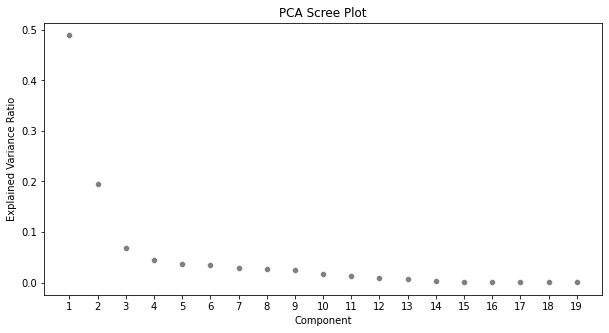

In [19]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x=range(1, len(pca.explained_variance_ratio_) + 1),
                     y=pca.explained_variance_ratio_,
                     color='Grey')


ax.set(title='PCA Scree Plot',
       xlabel='Component',
       ylabel='Explained Variance Ratio',
       xticks=range(1, len(pca.explained_variance_ratio_) + 1))

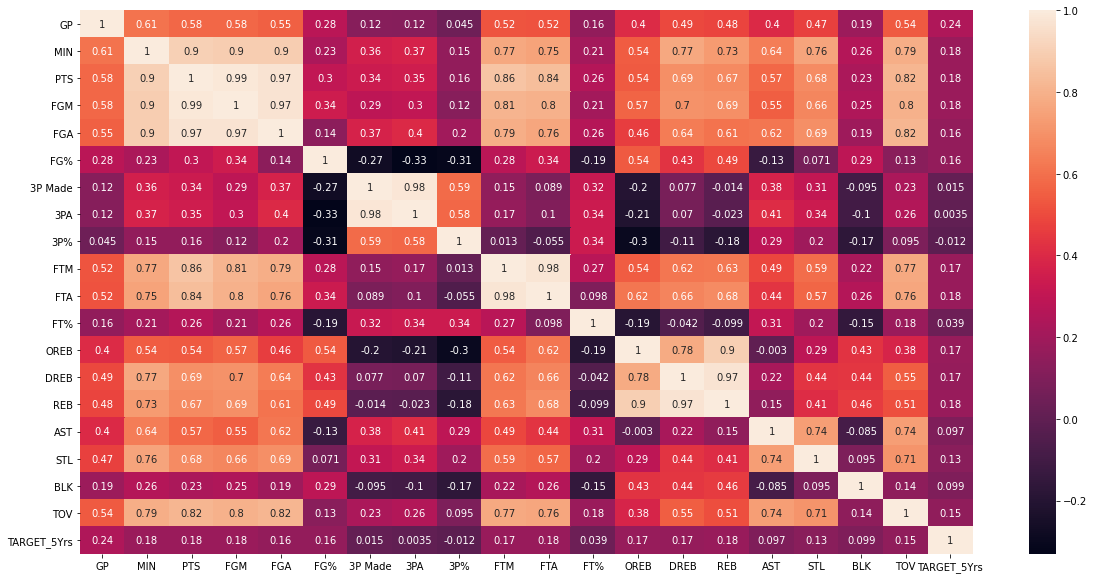

In [32]:
plt.figure(figsize=(20,10))
corrMatrix = df_train.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

There is some heavy colinearity in the dataset - the majority of the variance is explained in the first two PCs.

[Text(0.5, 1.0, 'PCA by Target'),
 Text(0.5, 0, 'First PC'),
 Text(0, 0.5, 'Second PC')]

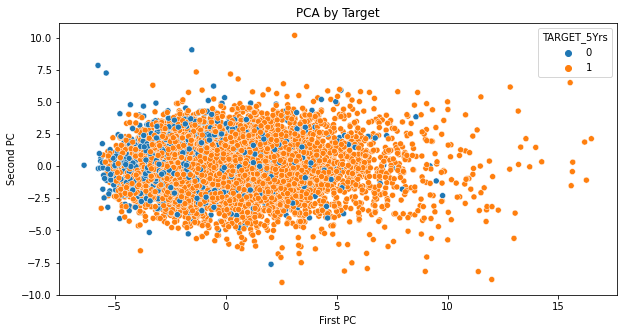

In [23]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x=pca_X[0],
                     y=pca_X[1],
                     hue=pca_X['TARGET_5Yrs'])


ax.set(title='PCA by Target',
       xlabel='First PC',
       ylabel='Second PC')

Significant outliers - appears that the lower the first PC, the lower the chance of being longer than 5 yr career.

### look into games played and minutes played

[Text(0.5, 1.0, 'Games and Minutes played by Target'),
 Text(0.5, 0, 'Games played'),
 Text(0, 0.5, 'Minutes played')]

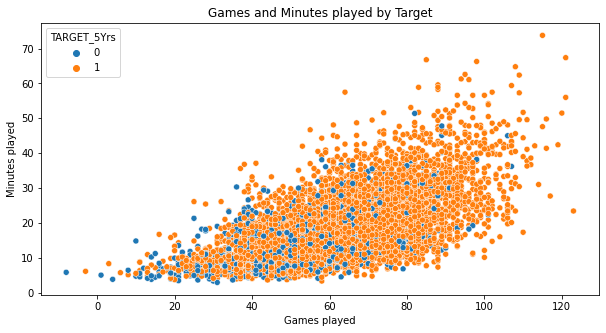

In [26]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x=df_train['GP'],
                     y=df_train['MIN'],
                     hue=df_train['TARGET_5Yrs'])


ax.set(title='Games and Minutes played by Target',
       xlabel='Games played',
       ylabel='Minutes played')

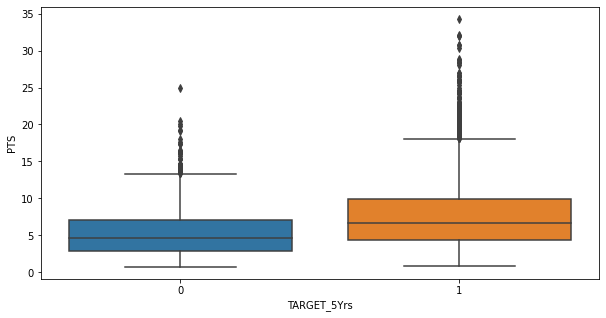

In [28]:
### Points per game

plt.figure(figsize=(10,5))
ax = sns.boxplot(y=df_train['PTS'],
                     x=df_train['TARGET_5Yrs'])

